# Wind Turbine Anomaly Detection - VAE Approach

## Overview
This notebook implements an **Unsupervised Anomaly Detection** pipeline using a **Variational Autoencoder (VAE)**.

### Concept
1.  **Assumption**: Failures are rare and statistically different from normal operation.
2.  **Training**: We train the VAE **only on healthy data**. The model learns to compress and reconstruct "normal" patterns.
3.  **Inference**: We pass new data through the VAE. 
    -   If the data is **Normal**, the **Reconstruction Error (MSE)** will be **Low**.
    -   If the data is a **Failure** (Anomaly), the model will fail to reconstruct it well, resulting in a **High MSE**.

## Pipeline
1.  **Data Loading & Split**: Temporal split (Train/Val/Test).
2.  **Filtering**: Remove failure samples from Train and Validation sets.
3.  **Feature Engineering**: Standard Scaling (Fit on Healthy Train).
4.  **VAE Model**: LSTM-based Encoder/Decoder.
5.  **Training**: Minimize Reconstruction Loss + KL Divergence.
6.  **Evaluation**: Analyze Reconstruction Error distributions and set a threshold.

In [33]:
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_curve, auc, precision_recall_curve, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [34]:
# Configuration
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

# Data Params
WINDOW_HOURS = 12
SEQ_LENGTH = 50
TRAIN_RATIO = 0.5
VAL_RATIO = 0.1

# Model Params
LATENT_DIM = 5    # Dimension of the bottleneck (z)
HIDDEN_DIM = 32
BATCH_SIZE = 64
NUM_EPOCHS = 50
LEARNING_RATE = 1e-3
PATIENCE = 5

## 1. Data Preparation

In [ ]:
# Load Data
scada = pd.read_csv("Datasets/SCADA/EDP-SCADA-2017.csv")
failure = pd.read_csv("Datasets/SCADA/EDP-Failure-2017.csv")

# Preprocessing
scada['Timestamp'] = pd.to_datetime(scada['Timestamp'])
failure['Timestamp'] = pd.to_datetime(failure['Timestamp'])
scada = scada.sort_values(['Turbine_ID', 'Timestamp']).reset_index(drop=True)
failure = failure.sort_values(['Turbine_ID', 'Timestamp']).reset_index(drop=True)


# Diferença entre o Óleo Hidráulico e a Temperatura na Nacelle (Ambiente interno)
scada['Hyd_Oil_Delta'] = scada['Hyd_Oil_Temp_Avg'] - scada['Nac_Temp_Avg']

# Diferença entre o Óleo Hidráulico e o Ambiente Externo (opcional, mas bom)
scada['Hyd_Oil_Amb_Delta'] = scada['Hyd_Oil_Temp_Avg'] - scada['Amb_Temp_Avg']

# SELEÇÃO ESPECIALISTA (Focada nas Falhas Reais do seu Dataset)
scada_cols = [
    # --- 1. Contexto Operacional (Carga) ---
    # Essenciais para o modelo saber se o aquecimento é por trabalho ou defeito
    'Amb_WindSpeed_Avg',       
    'Grd_Prod_Pwr_Avg',        
    'Gen_RPM_Avg',             

    # --- 2. Contexto Ambiental (Sazonalidade) ---
    # Essenciais para o modelo aprender que "Verão = Óleo mais quente" é normal
    'Amb_Temp_Avg',            # Temperatura externa (Sazonalidade macro)
    'Nac_Temp_Avg',            # Temperatura interna (Onde o equipamento vive)

    # --- 3. Indicadores Diretos de Falha (Sintomas) ---
    # Onde a falha hidráulica se manifesta fisicamente (vimos separação nos gráficos)
    'Gear_Oil_Temp_Avg',       # Forte correlação visual nos seus gráficos
    'Gear_Bear_Temp_Avg',      # Também mostrou deslocamento na falha
    'Hyd_Oil_Delta',
    'Hyd_Oil_Amb_Delta'
]

# Dica: Mantenha a lista enxuta assim. 
# Adicionar mais colunas só vai adicionar ruído e esconder o sinal da hidráulica.


for col in scada_cols:
    scada[col] = pd.to_numeric(scada[col], errors='coerce')
scada[scada_cols] = scada[scada_cols].fillna(scada[scada_cols].median())

# Labeling
def label_data(scada_df, failure_df, window_hours=12):
    scada_labeled = scada_df.copy()
    scada_labeled['Label'] = 0
    for _, fail_row in failure_df.iterrows():
        turbine = fail_row['Turbine_ID']
        fail_time = fail_row['Timestamp']
        mask = (
            (scada_labeled['Turbine_ID'] == turbine) &
            (scada_labeled['Timestamp'] <= fail_time) &
            (scada_labeled['Timestamp'] >= fail_time - pd.Timedelta(hours=window_hours))
        )
        scada_labeled.loc[mask, 'Label'] = 1
    return scada_labeled

hydraulic_failures = failure[failure['Component'] == 'HYDRAULIC_GROUP'].copy()

#scada_labeled = label_data(scada, failure, WINDOW_HOURS)
scada_labeled = label_data(scada, hydraulic_failures, WINDOW_HOURS)

print(f"Total Failures: {scada_labeled['Label'].sum()}")

Total Failures: 359


In [36]:
scada_labeled

,Turbine_ID,Timestamp,Gen_RPM_Max,Gen_RPM_Min,Gen_RPM_Avg,Gen_RPM_Std,Gen_Bear_Temp_Avg,Gen_Phase1_Temp_Avg,Gen_Phase2_Temp_Avg,Gen_Phase3_Temp_Avg,...,Grd_Prod_PsbleInd_Std,Grd_Prod_PsbleCap_Avg,Grd_Prod_PsbleCap_Max,Grd_Prod_PsbleCap_Min,Grd_Prod_PsbleCap_Std,Gen_Bear2_Temp_Avg,Nac_Direction_Avg,Hyd_Oil_Delta,Hyd_Oil_Amb_Delta,Label
0,T01,2017-01-01 00:00:00+00:00,1460.9,1239.2,1313.7,47.9,36.0,57,57,57,...,67.1,978.4,1000.0,621.9,67.1,45,108.1,2,12,0
1,T01,2017-01-01 00:10:00+00:00,1410.6,1229.4,1271.3,27.6,36.0,57,57,57,...,120.9,900.7,1000.0,477.2,120.9,44,108.1,2,12,0
2,T01,2017-01-01 00:20:00+00:00,1444.1,1226.7,1270.4,30.8,36.0,56,56,56,...,149.3,865.2,1000.0,291.4,149.3,44,114.7,2,12,0
3,T01,2017-01-01 00:30:00+00:00,1300.0,1228.1,1256.1,11.8,36.0,56,56,56,...,187.8,734.6,1000.0,222.0,187.8,43,114.7,3,12,0
4,T01,2017-01-01 00:40:00+00:00,1294.1,1221.2,1252.9,11.2,36.0,56,56,56,...,174.1,496.5,876.1,54.4,174.1,43,114.7,3,12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209231,T11,2017-12-31 23:10:00+00:00,1509.1,1226.6,1314.6,74.3,42.0,58,59,59,...,0.0,1000.0,1000.0,1000.0,0.0,39,318.2,4,12,0
209232,T11,2017-12-31 23:20:00+00:00,1313.6,1216.0,1252.7,15.6,42.0,58,59,58,...,51.2,983.5,1000.0,667.1,51.2,38,320.5,5,12,0
209233,T11,2017-12-31 23:30:00+00:00,1289.9,1220.4,1250.5,12.7,42.0,57,59,58,...,140.5,875.0,1000.0,382.9,140.5,38,326.3,5,12,0
209234,T11,2017-12-31 23:40:00+00:00,1421.2,1221.0,1268.9,37.3,42.0,57,58,57,...,68.8,979.6,1000.0,608.4,68.8,37,328.2,5,13,0


In [37]:
# Temporal Split
def temporal_split_raw_data(df, train_ratio=0.5, val_ratio=0.1):
    train_dfs, val_dfs, test_dfs = [], [], []
    for turbine in df['Turbine_ID'].unique():
        turbine_df = df[df['Turbine_ID'] == turbine].copy()
        n = len(turbine_df)
        train_end = int(n * train_ratio)
        val_end = int(n * (train_ratio + val_ratio))
        train_dfs.append(turbine_df.iloc[:train_end])
        val_dfs.append(turbine_df.iloc[train_end:val_end])
        test_dfs.append(turbine_df.iloc[val_end:])
    return pd.concat(train_dfs), pd.concat(val_dfs), pd.concat(test_dfs)

train_df_all, val_df_all, test_df = temporal_split_raw_data(scada_labeled, TRAIN_RATIO, VAL_RATIO)

# CRITICAL: Filter Healthy Data for Training
train_df_healthy = train_df_all[train_df_all['Label'] == 0].copy()
val_df_healthy = val_df_all[val_df_all['Label'] == 0].copy()

print(f"Train (Healthy Only): {train_df_healthy.shape}")
print(f"Val (Healthy Only):   {val_df_healthy.shape}")
print(f"Test (Mixed):         {test_df.shape} (Failures: {test_df['Label'].sum()})")

Train (Healthy Only): (104474, 86)
Val (Healthy Only):   (20922, 86)
Test (Mixed):         (83696, 86) (Failures: 215)


In [38]:
# Scaling (Fit on Healthy Train)
scaler = StandardScaler()
feature_cols = scada_cols

X_train_scaled = scaler.fit_transform(train_df_healthy[feature_cols])
X_val_scaled = scaler.transform(val_df_healthy[feature_cols])
X_test_scaled = scaler.transform(test_df[feature_cols])

# Sequence Creation
def create_sequences(X, y, turbine_ids, seq_length=50):
    sequences = []
    labels = []
    unique_turbines = np.unique(turbine_ids)
    for turbine in unique_turbines:
        turbine_mask = turbine_ids == turbine
        X_turbine = X[turbine_mask]
        y_turbine = y[turbine_mask]
        if len(X_turbine) < seq_length: continue
        for i in range(len(X_turbine) - seq_length + 1):
            sequences.append(X_turbine[i:i+seq_length])
            labels.append(y_turbine[i+seq_length-1])
    return np.array(sequences), np.array(labels)

print("Generating sequences...")
X_train_seq, _ = create_sequences(X_train_scaled, train_df_healthy['Label'].values, train_df_healthy['Turbine_ID'].values, SEQ_LENGTH)
X_val_seq, _ = create_sequences(X_val_scaled, val_df_healthy['Label'].values, val_df_healthy['Turbine_ID'].values, SEQ_LENGTH)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, test_df['Label'].values, test_df['Turbine_ID'].values, SEQ_LENGTH)

print(f"Train Sequences: {X_train_seq.shape}")

Generating sequences...
Train Sequences: (104278, 50, 6)


In [39]:
class VAEDataset(Dataset):
    def __init__(self, X):
        self.X = torch.FloatTensor(X)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx]

train_loader = DataLoader(VAEDataset(X_train_seq), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(VAEDataset(X_val_seq), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(VAEDataset(X_test_seq), batch_size=BATCH_SIZE, shuffle=False)

## 2. VAE Architecture

In [40]:
class VAE(nn.Module):
    def __init__(self, input_dim, seq_length, hidden_dim=64, latent_dim=10):
        super(VAE, self).__init__()
        self.seq_length = seq_length
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder_lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder
        self.decoder_fc = nn.Linear(latent_dim, hidden_dim)
        self.decoder_lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.output_layer = nn.Linear(hidden_dim, input_dim)
        
    def encode(self, x):
        _, (h_n, _) = self.encoder_lstm(x)
        h_n = h_n[-1] # Last hidden state
        mu = self.fc_mu(h_n)
        logvar = self.fc_logvar(h_n)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        # Repeat z for each time step to feed into LSTM decoder
        # (Batch, Latent) -> (Batch, Seq_Len, Latent) ?? 
        # Alternative: Use z as initial hidden state or input at each step.
        # Simple approach: Map z -> hidden -> Repeat -> LSTM
        
        h = torch.relu(self.decoder_fc(z))
        # Repeat h for sequence length
        h_repeated = h.unsqueeze(1).repeat(1, self.seq_length, 1)
        
        out, _ = self.decoder_lstm(h_repeated)
        reconstruction = self.output_layer(out)
        return reconstruction
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        reconstruction = self.decode(z)
        return reconstruction, mu, logvar

In [41]:
def loss_function(recon_x, x, mu, logvar):
    MSE = nn.MSELoss(reduction='sum')(recon_x, x)
    # KL Divergence: 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE(input_dim=X_train_seq.shape[2], seq_length=SEQ_LENGTH, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("Starting Training on Healthy Data...")
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0
    for X_batch in train_loader:
        X_batch = X_batch.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(X_batch)
        loss = loss_function(recon_batch, X_batch, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch in val_loader:
            X_batch = X_batch.to(device)
            recon_batch, mu, logvar = model(X_batch)
            val_loss += loss_function(recon_batch, X_batch, mu, logvar).item()
            
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_val_loss = val_loss / len(val_loader.dataset)
    
    print(f'Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_vae.pth')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("Early Stopping")
            break

model.load_state_dict(torch.load('best_vae.pth'))

Starting Training on Healthy Data...
Epoch 1: Train Loss: 144.4398, Val Loss: 164.3156
Epoch 2: Train Loss: 109.3008, Val Loss: 157.1714
Epoch 3: Train Loss: 99.9874, Val Loss: 139.5284
Epoch 4: Train Loss: 92.9323, Val Loss: 138.3594
Epoch 5: Train Loss: 91.1086, Val Loss: 135.2952
Epoch 6: Train Loss: 89.6499, Val Loss: 137.0684
Epoch 7: Train Loss: 89.0405, Val Loss: 134.9217
Epoch 8: Train Loss: 88.4160, Val Loss: 134.1424
Epoch 9: Train Loss: 87.8502, Val Loss: 133.5042
Epoch 10: Train Loss: 87.2386, Val Loss: 133.7031


KeyboardInterrupt: 

## 3. Anomaly Detection & Evaluation

In [42]:
unique, counts = np.unique(y_test_seq, return_counts=True)
count_dict = dict(zip(unique, counts))

print("=== Teste sequence count ===")
print(f"Normal sequences (0): {count_dict.get(0, 0)}")
print(f"Failure sequences (1): {count_dict.get(1, 0)}")

total = len(y_test_seq)
pct_falha = (count_dict.get(1, 0) / total) * 100
print(f"Failure percentage: {pct_falha:.4f}%")

=== Teste sequence count ===
Normal sequences (0): 83285
Failure sequences (1): 215
Failure percentage: 0.2575%


In [43]:
def get_reconstruction_errors(model, loader, device):
    model.eval()
    errors = []
    with torch.no_grad():
        for X_batch in loader:
            X_batch = X_batch.to(device)
            recon_batch, _, _ = model(X_batch)
            # MSE per sample: Mean over features and sequence length
            # Shape: (Batch, Seq, Feat)
            loss = nn.MSELoss(reduction='none')(recon_batch, X_batch)
            # Mean over seq and feat dimensions -> (Batch,)
            sample_loss = loss.mean(dim=(1, 2))
            errors.extend(sample_loss.cpu().numpy())
    return np.array(errors)

print("Calculating reconstruction errors...")
val_errors = get_reconstruction_errors(model, val_loader, device)

#test_errors = pd.Series(test_errors).rolling(window=12).mean().fillna(0).values
test_errors = get_reconstruction_errors(model, test_loader, device)

Calculating reconstruction errors...


Re-gerando labels com janela de 48h para avaliação...
Novos labels de falha (48h): 857 sequências
ROC AUC Score (48h window): 0.5987

Melhor Threshold: 1.2108
Melhor F1-Score (48h window): 0.1081

Relatório de Classificação (Considerando 48h antes da falha como Real):
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     82643
           1       0.08      0.18      0.11       857

    accuracy                           0.97     83500
   macro avg       0.53      0.58      0.55     83500
weighted avg       0.98      0.97      0.98     83500



C:\Users\tibis\AppData\Local\Temp\ipykernel_96696\257063132.py:33: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precisions * recalls) / (precisions + recalls)


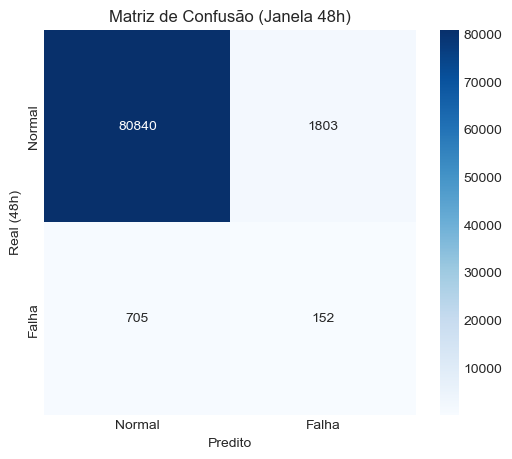

In [51]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, classification_report, confusion_matrix

# --- CONFIGURAÇÃO ---
EVAL_WINDOW_HOURS = 48  # Defina aqui o tamanho da janela de avaliação (em horas)
# --------------------

# --- 1. Re-Labeling com Janela Personalizada (Apenas para Avaliação) ---
print(f"Re-gerando labels com janela de {EVAL_WINDOW_HOURS}h para avaliação...")

# Usamos o test_df original, mas aplicamos a nova janela
test_df_eval = label_data(test_df.copy(), hydraulic_failures, window_hours=EVAL_WINDOW_HOURS)

# Precisamos recriar as sequências para garantir que os labels alinhem com X_test_seq
# Nota: Usamos X_test_scaled apenas para manter a estrutura, mas só nos importamos com o 'y' retornado
_, y_test_seq_eval = create_sequences(
    X_test_scaled, 
    test_df_eval['Label'].values, 
    test_df_eval['Turbine_ID'].values, 
    SEQ_LENGTH
)

print(f"Novos labels de falha ({EVAL_WINDOW_HOURS}h): {sum(y_test_seq_eval)} sequências")


# --- 2. Calcular Métricas com o Novo Gabarito ---

# ROC AUC
auc = roc_auc_score(y_test_seq_eval, test_errors)
print(f"ROC AUC Score ({EVAL_WINDOW_HOURS}h window): {auc:.4f}")

# Encontrar Melhor Threshold (F1-Score)
precisions, recalls, thresholds = precision_recall_curve(y_test_seq_eval, test_errors)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
f1_scores = np.nan_to_num(f1_scores)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"\nMelhor Threshold: {best_threshold:.4f}")
print(f"Melhor F1-Score ({EVAL_WINDOW_HOURS}h window): {best_f1:.4f}")

# Relatório Final
y_pred = (test_errors >= best_threshold).astype(int)

print(f"\nRelatório de Classificação (Considerando {EVAL_WINDOW_HOURS}h antes da falha como Real):")
print(classification_report(y_test_seq_eval, y_pred))

# Matriz de Confusão
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test_seq_eval, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Falha'], yticklabels=['Normal', 'Falha'])
plt.title(f"Matriz de Confusão (Janela {EVAL_WINDOW_HOURS}h)")
plt.ylabel(f'Real ({EVAL_WINDOW_HOURS}h)')
plt.xlabel('Predito')
plt.show()

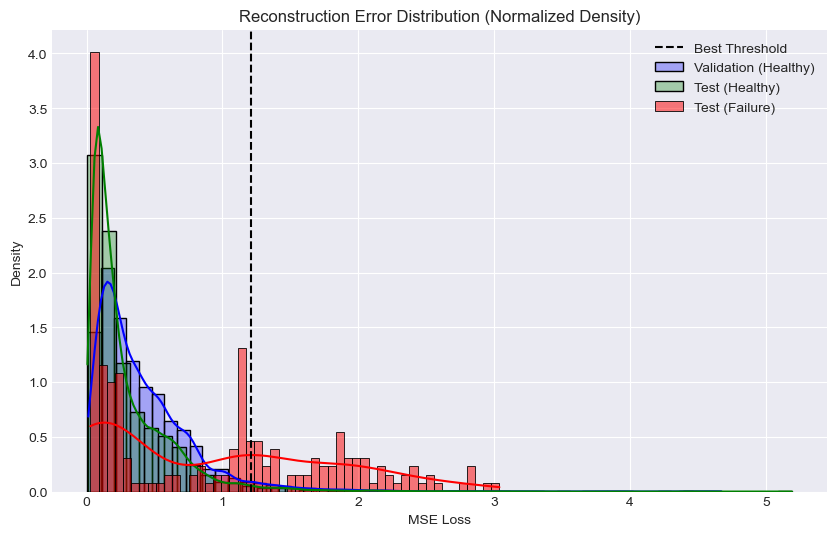

In [54]:
# Visualize Distributions (Normalizado)
plt.figure(figsize=(10, 6))

# Adicionei stat='density' e common_norm=False para normalizar as alturas
sns.histplot(val_errors, bins=50, label='Validation (Healthy)', color='blue', alpha=0.3, kde=True, stat='density', common_norm=False)
sns.histplot(test_errors[y_test_seq==0], bins=50, label='Test (Healthy)', color='green', alpha=0.3, kde=True, stat='density', common_norm=False)
sns.histplot(test_errors[y_test_seq==1], bins=50, label='Test (Failure)', color='red', alpha=0.5, kde=True, stat='density', common_norm=False)

plt.axvline(best_threshold, color='k', linestyle='--', label='Best Threshold')

plt.title("Reconstruction Error Distribution (Normalized Density)")
plt.xlabel("MSE Loss")
plt.ylabel("Density") # Mudou de Count para Density
plt.legend()
plt.show()

Total de eventos de falha encontrados: 3


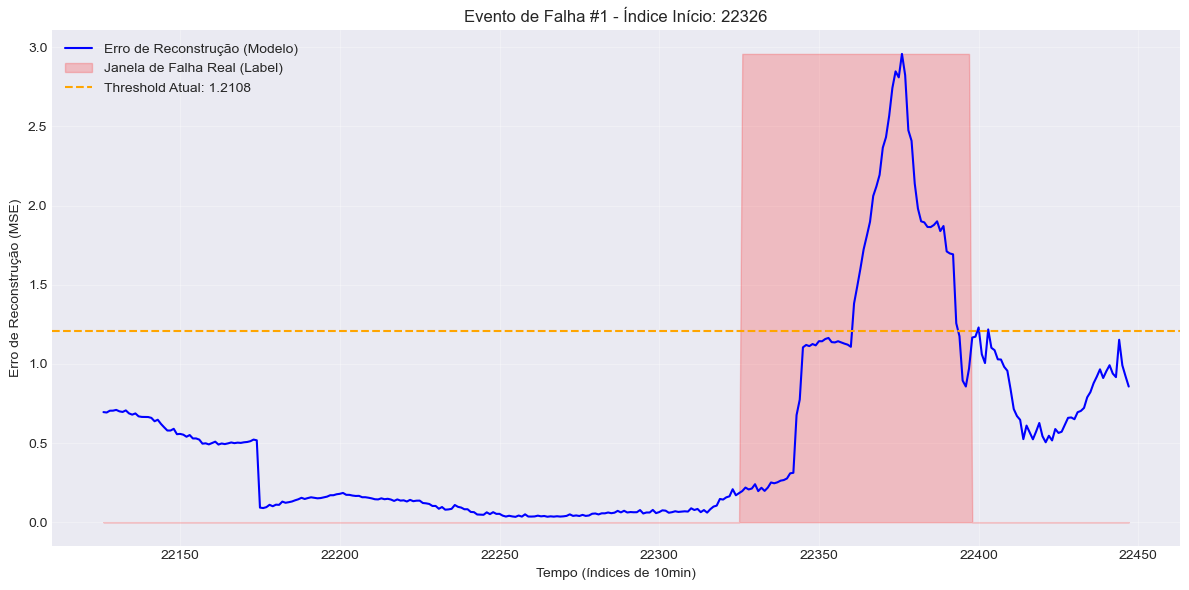

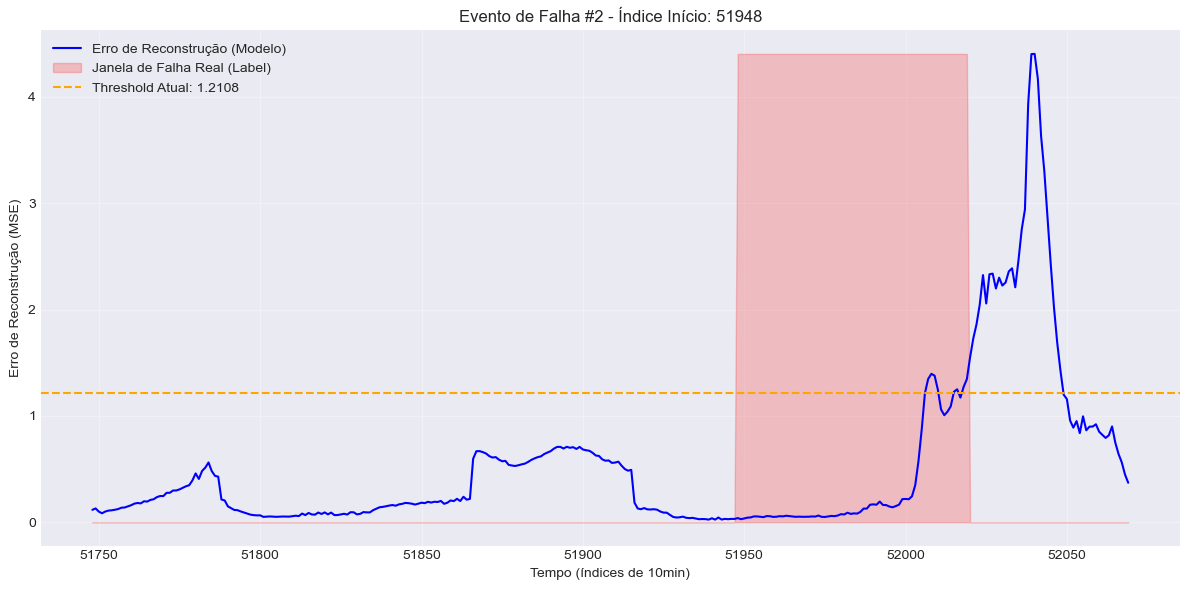

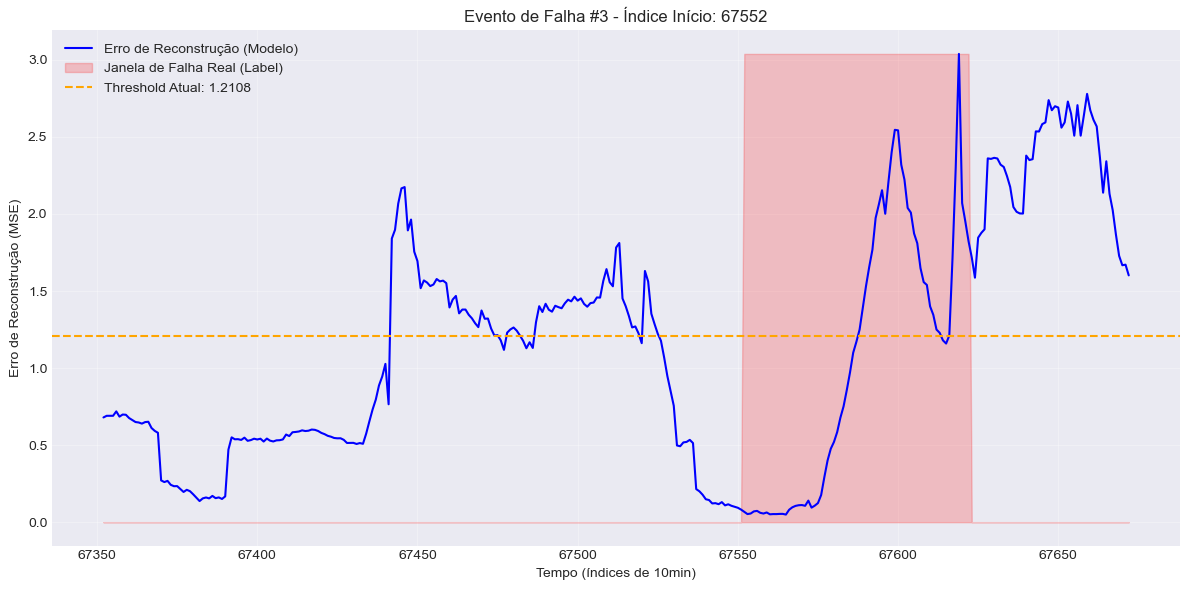

In [52]:
# Identificar onde começam os eventos de falha (transição de 0 para 1)
failure_starts = []
in_failure = False
for i in range(len(y_test_seq)):
    if y_test_seq[i] == 1 and not in_failure:
        failure_starts.append(i)
        in_failure = True
    elif y_test_seq[i] == 0:
        in_failure = False

print(f"Total de eventos de falha encontrados: {len(failure_starts)}")

if len(failure_starts) > 0:
    # Loop para plotar TODOS os eventos de falha
    for i, start_idx in enumerate(failure_starts):
        # Definir janela de visualização: 
        # 200 pontos antes (contexto ~33h) até 50 pontos depois do fim da falha
        plot_start = max(0, start_idx - 200)
        
        # Encontrar onde a falha atual termina
        current_end = start_idx
        while current_end < len(y_test_seq) and y_test_seq[current_end] == 1:
            current_end += 1
        
        plot_end = min(len(test_errors), current_end + 50)
        
        plt.figure(figsize=(12, 6))
        
        # Plotar Erro de Reconstrução (Sinal do Modelo)
        plt.plot(range(plot_start, plot_end), test_errors[plot_start:plot_end], 
                 label='Erro de Reconstrução (Modelo)', color='blue', linewidth=1.5)
        
        # Plotar Label de Falha (Realidade) - Área sombreada vermelha
        # Usamos o max do erro na janela para escalar a altura da área sombreada
        max_val_in_window = np.max(test_errors[plot_start:plot_end]) if len(test_errors[plot_start:plot_end]) > 0 else 1
        plt.fill_between(range(plot_start, plot_end), 
                         0, 
                         y_test_seq[plot_start:plot_end] * max_val_in_window, 
                         color='red', alpha=0.2, label='Janela de Falha Real (Label)')
        
        # Linhas de Threshold
        plt.axhline(best_threshold, color='orange', linestyle='--', label=f'Threshold Atual: {best_threshold:.4f}')
        
        plt.title(f"Evento de Falha #{i+1} - Índice Início: {start_idx}")
        plt.xlabel("Tempo (índices de 10min)")
        plt.ylabel("Erro de Reconstrução (MSE)")
        plt.legend(loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
else:
    print("Nenhuma falha encontrada no conjunto de teste para visualizar.")